In [3]:
import pandas as pd
import numpy as np
from datetime import datetime
import pysindy as ps
import warnings
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import ElasticNet
from pysr3.linear.models import LinearL1ModelSR3



# Working real priced options


### Loading Data

#### Nifty Options

In [4]:
# Data from the last 15 years of NIFTY index option https://github.com/gurdeep101/fattailgain/tree/main/nifty_option_data_15yr
df_nifty = pd.read_csv('data/nifty_15 yr_data.csv')
df_nifty['Date'] = pd.to_datetime(df_nifty['Date'])
df_nifty['Expiry'] = pd.to_datetime(df_nifty['Expiry'])
df_nifty.sort_values('Date', inplace=True)

In [5]:
df_nifty['Expiry'].unique()

<DatetimeArray>
['2006-06-29 00:00:00', '2006-07-27 00:00:00', '2007-10-25 00:00:00',
 '2007-09-27 00:00:00', '2007-11-29 00:00:00', '2007-12-27 00:00:00',
 '2008-01-31 00:00:00', '2008-02-28 00:00:00', '2008-03-27 00:00:00',
 '2008-04-24 00:00:00',
 ...
 '2020-03-26 00:00:00', '2020-04-30 00:00:00', '2020-05-28 00:00:00',
 '2020-06-25 00:00:00', '2020-07-30 00:00:00', '2020-08-27 00:00:00',
 '2020-09-24 00:00:00', '2020-10-29 00:00:00', '2020-11-26 00:00:00',
 '2020-12-31 00:00:00']
Length: 159, dtype: datetime64[ns]

In [6]:
option_data = df_nifty[(df_nifty['Expiry'] == '2020-03-26 00:00:00') & (df_nifty['Option Type'] == 'CE') & (df_nifty['Number of Contracts'] > 0) & (df_nifty['Strike Price'] == 11000.0)]

In [7]:
option_data

,Date,Symbol,Expiry,Option Type,Strike Price,Open,High,Low,Close,Last,Settle Price,Number of Contracts,Turnover,Premium Turnover,Open Interest,Change in OI,Underlying
129661,2020-01-01,NIFTY,2020-03-26,CE,11000.0,1325.00,1325.00,1325.00,1325.00,1325.00,1332.85,1,9.240000e+05,99000.0,62175,75,12182.50
129662,2020-01-02,NIFTY,2020-03-26,CE,11000.0,1369.40,1410.00,1369.40,1410.00,1410.00,1410.00,3,2.788000e+06,313000.0,62400,225,12282.20
129663,2020-01-03,NIFTY,2020-03-26,CE,11000.0,1371.00,1371.00,1340.00,1366.35,1366.35,1366.35,3,2.781000e+06,306000.0,62250,-150,12226.65
129664,2020-01-06,NIFTY,2020-03-26,CE,11000.0,1230.80,1230.80,1142.95,1148.40,1155.00,1148.40,15,1.368900e+07,1314000.0,62100,-150,11993.05
129665,2020-01-07,NIFTY,2020-03-26,CE,11000.0,1225.00,1275.00,1186.00,1215.00,1215.55,1215.00,14,1.283900e+07,1289000.0,62475,375,12052.95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129717,2020-03-20,NIFTY,2020-03-26,CE,11000.0,7.75,7.75,3.05,3.70,3.10,3.70,49437,4.080100e+10,15478000.0,1341300,-165525,8745.45
129718,2020-03-23,NIFTY,2020-03-26,CE,11000.0,1.85,6.00,1.45,3.05,2.90,3.05,18220,1.503637e+10,4873000.0,1205700,-135600,7610.25
129719,2020-03-24,NIFTY,2020-03-26,CE,11000.0,3.55,3.55,1.50,1.90,1.90,1.90,19755,1.630118e+10,3309000.0,1155450,-50250,7801.05
129720,2020-03-25,NIFTY,2020-03-26,CE,11000.0,1.05,2.20,1.05,1.60,1.60,1.60,13689,1.129485e+10,1429000.0,1002675,-152775,8317.85


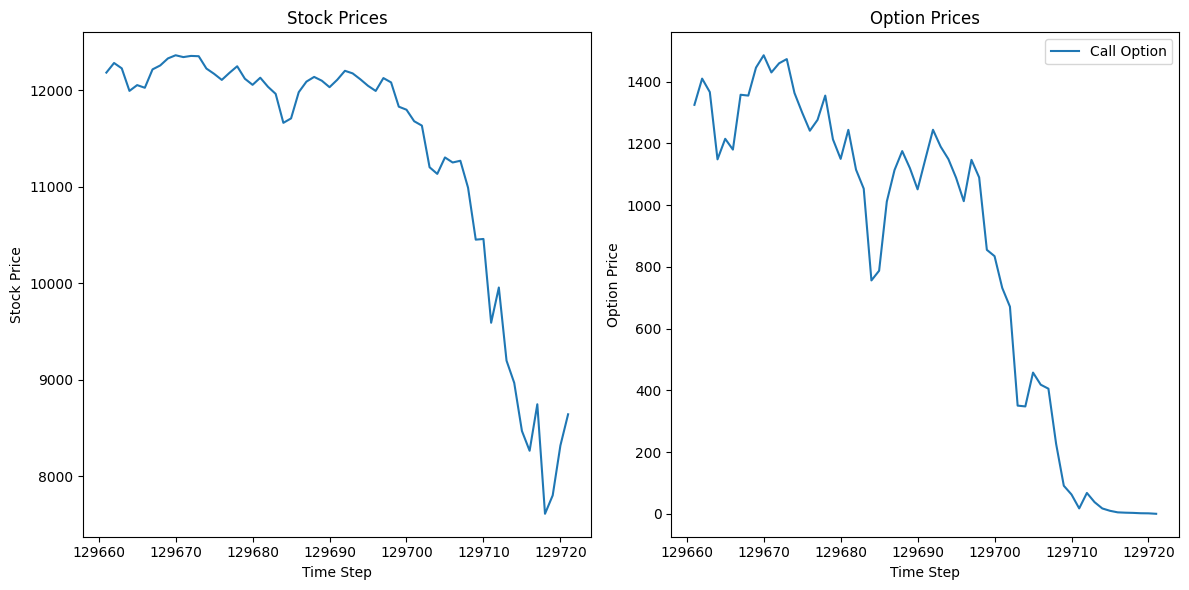

In [8]:
# Plot the simulated stock prices and option prices
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(option_data['Underlying'])
plt.title('Stock Prices')
plt.xlabel('Time Step')
plt.ylabel('Stock Price')

plt.subplot(1, 2, 2)
plt.plot(option_data['Close'], label='Call Option')
# plt.plot(option_prices_put, label='Put Option')
plt.title('Option Prices')
plt.xlabel('Time Step')
plt.ylabel('Option Price')
plt.legend()

plt.tight_layout()
plt.show()

### Calculating Derivates

In [9]:

plt.ion()

# ignore user warnings
warnings.filterwarnings("ignore", category=UserWarning)

integrator_keywords = {}
integrator_keywords["rtol"] = 1e-12
integrator_keywords["method"] = "LSODA"
integrator_keywords["atol"] = 1e-12

In [10]:
diffs = [
    ("PySINDy Finite Difference", ps.FiniteDifference()),
    ("Finite Difference", ps.SINDyDerivative(kind="finite_difference", k=1)),
    ("Smoothed Finite Difference", ps.SmoothedFiniteDifference()),
    (
        "Savitzky Golay",
        ps.SINDyDerivative(kind="savitzky_golay", left=0.5, right=0.5, order=3),
    ),
    ("Spline", ps.SINDyDerivative(kind="spline", s=1e-2)),
    ("Trend Filtered", ps.SINDyDerivative(kind="trend_filtered", order=0, alpha=1e-2)),
    ("Spectral", ps.SINDyDerivative(kind="spectral")),
    ("Spectral, PySINDy version", ps.SpectralDerivative()),
    ("Kalman", ps.SINDyDerivative(kind="kalman", alpha=0.05)),
]

plot_kws = dict(alpha=0.7, linewidth=3)
pal = sns.color_palette("Set1")

In [11]:
def plot_data_and_derivative(x,dt,diffs):
    t = np.linspace(0,len(x)-1,int(len(x)/dt))
    plt.figure(figsize=(10,15))

    plt.subplot(2,1,1)
    plt.title('Price')
    plt.plot(t,x)

    plt.title('Price derivative')
    plt.subplot(2,1,2)

    for i in diffs:
        diff = i[1](x,t)
        plt.legend([diff[0] for diff in diffs])
        plt.plot(t,diff)


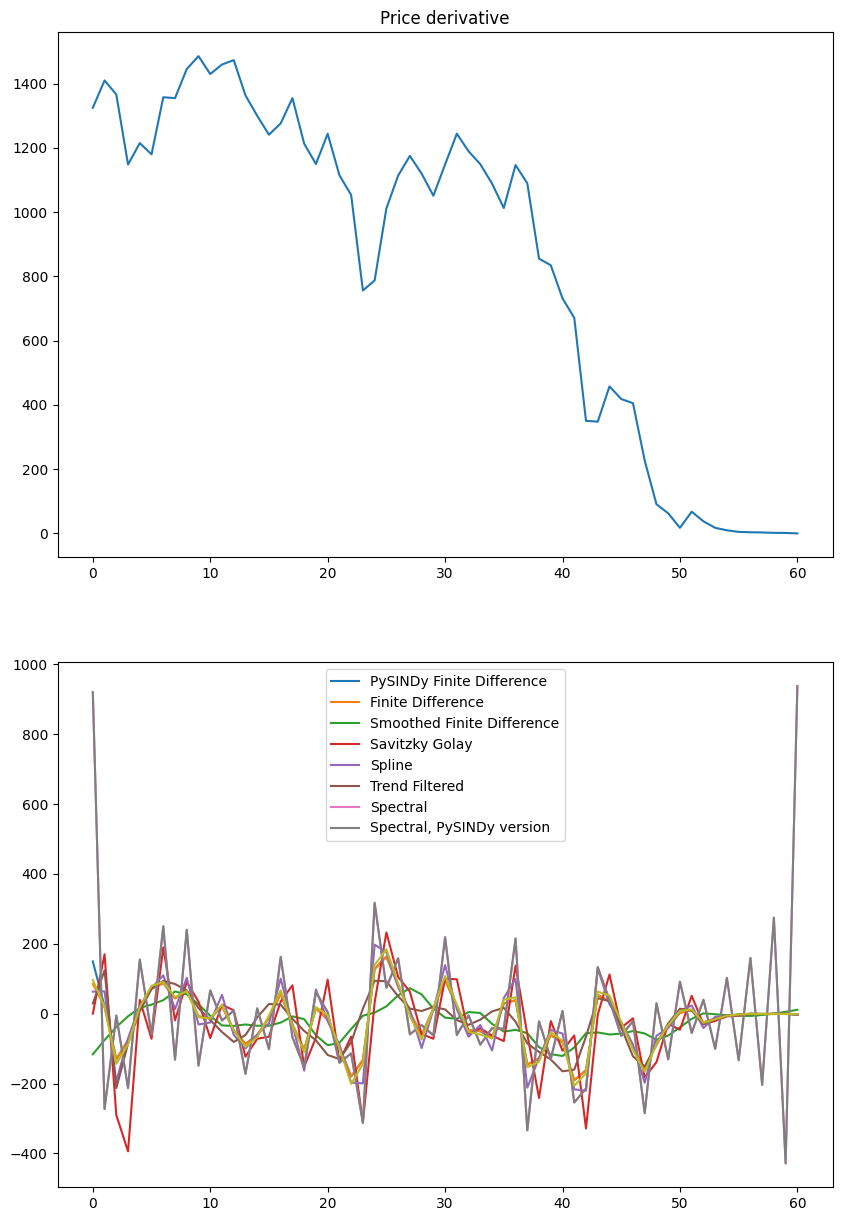

In [12]:
plot_data_and_derivative(option_data['Close'].values,1.,diffs)


### Building Library

In [13]:
def ConvSmoother(x, p, sigma):
    """
    Smoother for noisy data
    
    Inpute = x, p, sigma
    x = one dimensional series to be smoothed
    p = width of smoother
    sigma = standard deviation of gaussian smoothing kernel
    """
    
    n = len(x)
    y = np.zeros(n, dtype=np.float64)
    g = np.exp(-np.power(np.linspace(-p,p,2*p),2)/(2.0*sigma**2))

    for i in range(n):
        a = max([i-p,0])
        b = min([i+p,n])
        c = max([0, p-i])
        d = min([2*p,p+n-i])
        y[i] = np.sum(np.multiply(x[a:b], g[c:d]))/np.sum(g[c:d])
        
    return y


def calculate_backward_difference(series):
    series = ConvSmoother(series,len(series)//10,2)
    backward_differences = np.array([series[i] - series[i-1] for i in range(1, len(series))])
    return backward_differences


def build_differentiate_library(variables, variable_names, max_degree=2, smoothing_factor=0.01):
    '''
    Build a differentiate library until dth degree calculating partial derivative of y in respect to X using smoothed finite difference method (backward difference)
    '''
    dx = calculate_backward_difference(variables[0])
    dy = np.concatenate(([0],calculate_backward_difference(variables[1])))
    derivatives = [dy]
    derivative_variable_names = [f'{variable_names[1]}_t'] 

    for var, var_name in zip(variables, variable_names):
        derivatives.append(var)
        derivative_variable_names.append(var_name)
    

    for degree in range(1, max_degree + 1):
        current_derivative = calculate_backward_difference(derivatives[-1])/dx
        current_derivative_smoothed = current_derivative
        derivatives.append(np.concatenate(([0], current_derivative_smoothed)))
        derivative_variable_names.append(f"{variable_names[-1]}_{variable_names[0]*degree}")

    return derivatives, derivative_variable_names

def build_polynomial_library(variables, variable_names, max_degree=2):
    '''
    Build a Polynomial library with variables until max_degree and cross-terms
    '''
    library = []
    variable_names_list = []

    for degree in range(1, max_degree + 1):
        for var, var_name in zip(variables, variable_names):
            library.append(var ** degree)
            variable_names_list.append(f"({var_name})^{degree}")


    return library , variable_names_list

def build_cross_library(variables, variable_names):
    lib_temp = []
    v_name_temp = []

    for i in range(len(variable_names)):
        for j in range(i + 1, len(variable_names)):
            lib_temp.append(variables[i] * variables[j])
            v_name_temp.append(f"({variable_names[i]}) * ({variable_names[j]})")
    
    return lib_temp,v_name_temp

In [14]:
variable_names = ['S', 'V']

price = option_data['Close'].values
underlying = option_data['Underlying'].values
# tal = calls['time_to_exp'].values

In [15]:
derivatives_values,derivatives_names = build_differentiate_library([underlying,price],variable_names,max_degree=3)

feature_library = np.array(derivatives_values[1:])
feature_names = derivatives_names[1:] #Exclude The first derivative

# y = np.array(library_values[1]).reshape(-1,1)

# library_values,library_names = build_polynomial_library(feature_library,feature_names, max_degree=2)

library_values,library_names = build_cross_library(feature_library,feature_names)

### Fitting Model

In [16]:
def iterative_threshold_ridge(X, y, threshold=0.1, alpha=1.0, max_iterations=10):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    remaining_coeffs = np.zeros(X.shape[1])
    remaining_indices = np.array(range(X.shape[1]))

    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
    for _ in range(max_iterations):
        model = Ridge(alpha=alpha)
        model.fit(X_train, y_train)
        coeffs = model.coef_[0]
        remaining_indices_temp = np.where(np.abs(coeffs) >= threshold)
        if len(remaining_indices_temp[0]) == 0:
            print(f'threshold ({threshold}) is forcing coefficients towards 0')
            break

        remaining_indices = remaining_indices[remaining_indices_temp]
        X_train = X_train[:, remaining_indices_temp[0]]

    remaining_coeffs[remaining_indices] = coeffs
    X_test = X_test[:, remaining_indices]
    y_pred = model.predict(X_test)
    final_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    # print(final_rmse)
    return remaining_coeffs,final_rmse


def SINDy_regression(X, y, opt = ps.STLSQ, **kwargs):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
    opt = opt(**kwargs)
    lib = ps.IdentityLibrary()

    model = ps.SINDy(feature_library=lib, optimizer=opt)
    model.fit(X_train, x_dot = y_train)

    remaining_coeffs = model.coefficients()
    y_pred = model.predict(X_test)
    final_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    # print(final_rmse)
    return remaining_coeffs,final_rmse


def SR3_regression(X, y, lam=1.0,el=1e5):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    model = LinearL1ModelSR3(lam=lam,el = el)

    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)

    coeffs = model.coef_

    return coeffs, mse


def lasso_regression(X, y, alpha=1.0):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    model = Lasso(alpha=alpha)
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)

    coeffs = model.coef_

    return coeffs, mse

def elastic_net_regression(X, y, alpha=1.0, l1_ratio=0.5):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)

    coeffs = model.coef_

    return coeffs, mse

def print_pde(w, rhs_description, ut='u_t', threshold=1e-6):
    pde = ut + ' = '
    terms = []

    for i in range(len(w)):
        if abs(w[i].real) > threshold:
            terms.append("(%05f)" % w[i].real + rhs_description[i] + '\n')

    if terms:
        pde += ' + '.join(terms)
        pde = pde.replace('+ -', '- ')
    else:
        return None

    return pde

PDE derived using STRidge
22.690751255882383
V_t = (21.156887)(S) * (V)
 + (-60.569110)(S) * (V_S)
 + (4.404730)(S) * (V_SS)
 + (-2.022315)(S) * (V_SSS)
 + (47.306037)(V) * (V_S)
 + (5.115794)(V) * (V_SS)
 + (-2.494964)(V) * (V_SSS)
 + (17.127854)(V_S) * (V_SS)
 + (0.517233)(V_S) * (V_SSS)
 + (0.457656)(V_SS) * (V_SSS)



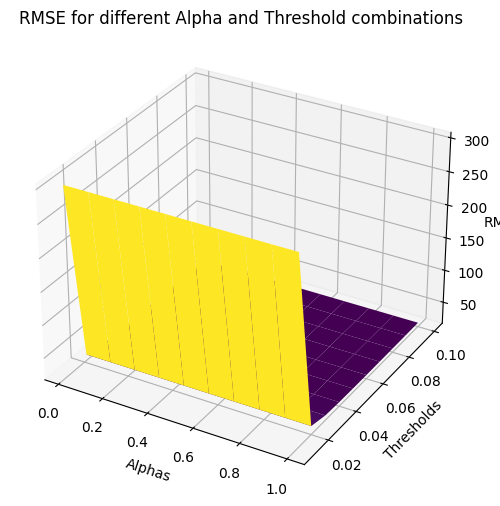

In [17]:
# Solve with STRidge
X = np.array(library_values).T[6:]
y = np.array(derivatives_values[0]).reshape(-1,1)[6:]

feature_names = library_names
alphas = np.linspace(0.01,1.,25)
thresholds = np.linspace(0.01,1.,25)

grid = np.array(np.meshgrid(alphas, thresholds)).T.reshape(-1, 2)

best = float('inf')
pdes = []
rmses = []

for idx, obj in enumerate(grid):
    alpha, threshold = obj
    w,best_rmse = iterative_threshold_ridge(X,y,threshold=threshold,alpha=alpha)
    pdes.append(print_pde(w,feature_names ,'V_t'))
    rmses.append(best_rmse)
    if best_rmse < best:
        best_coef = w
        best = best_rmse
        best_idx = idx

print("PDE derived using STRidge")
print(rmses[best_idx])
print(pdes[best_idx])
# Create meshgrid for 3D plot
alpha_mesh, threshold_mesh = np.meshgrid(alphas, thresholds)

# Convert rmses to a 2D array for the mesh
rmses_mesh = np.array(rmses).reshape(len(alphas), len(thresholds))

# Create the 3D plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(alpha_mesh, threshold_mesh, rmses_mesh, cmap='viridis')

ax.set_xlabel('Alphas')
ax.set_ylabel('Thresholds')
ax.set_zlabel('RMSE')
plt.title("RMSE for different Alpha and Threshold combinations")

plt.show()


In [18]:
for p in pdes:
    if p is not None:
        print(p)

V_t = (12.717876)(S) * (V)
 + (-76.687910)(S) * (V_S)
 + (14.375344)(S) * (V_SS)
 + (-78.300462)(S) * (V_SSS)
 + (72.346235)(V) * (V_S)
 + (-63.082807)(V) * (V_SS)
 + (-101.043581)(V) * (V_SSS)
 + (42.289380)(V_S) * (V_SS)
 + (58.546908)(V_S) * (V_SSS)
 + (19.741693)(V_SS) * (V_SSS)

V_t = (12.717876)(S) * (V)
 + (-76.687910)(S) * (V_S)
 + (14.375344)(S) * (V_SS)
 + (-78.300462)(S) * (V_SSS)
 + (72.346235)(V) * (V_S)
 + (-63.082807)(V) * (V_SS)
 + (-101.043581)(V) * (V_SSS)
 + (42.289380)(V_S) * (V_SS)
 + (58.546908)(V_S) * (V_SSS)
 + (19.741693)(V_SS) * (V_SSS)

V_t = (12.717876)(S) * (V)
 + (-76.687910)(S) * (V_S)
 + (14.375344)(S) * (V_SS)
 + (-78.300462)(S) * (V_SSS)
 + (72.346235)(V) * (V_S)
 + (-63.082807)(V) * (V_SS)
 + (-101.043581)(V) * (V_SSS)
 + (42.289380)(V_S) * (V_SS)
 + (58.546908)(V_S) * (V_SSS)
 + (19.741693)(V_SS) * (V_SSS)

V_t = (12.717876)(S) * (V)
 + (-76.687910)(S) * (V_S)
 + (14.375344)(S) * (V_SS)
 + (-78.300462)(S) * (V_SSS)
 + (72.346235)(V) * (V_S)
 + (-63.0

PDE derived using STRidge
357.66089027176133
V_t = (23.688341)(S) * (V)
 + (-89.225301)(S) * (V_S)
 + (316.790115)(S) * (V_SS)
 + (-2373.841909)(S) * (V_SSS)
 + (72.860774)(V) * (V_S)
 + (-679.639970)(V) * (V_SS)
 + (664.237218)(V) * (V_SSS)
 + (126.095577)(V_S) * (V_SS)
 + (643.063161)(V_S) * (V_SSS)
 + (1720.507592)(V_SS) * (V_SSS)



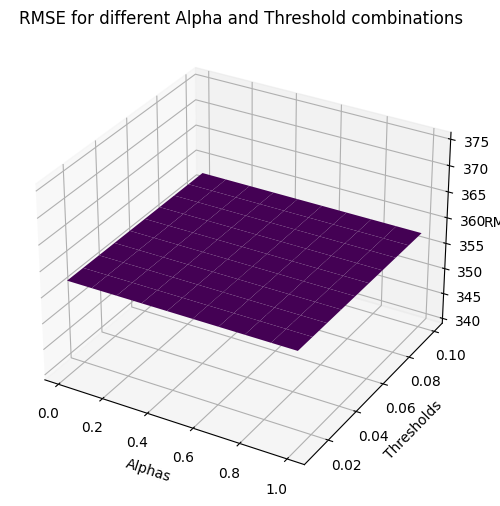

In [27]:
# Solve with PySINDy
X = np.array(library_values).T[6:]
y = np.array(derivatives_values[0]).reshape(-1,1)[6:]

feature_names = library_names
alphas = np.linspace(0.01,1.,10)
thresholds = np.linspace(0.01,0.1,10)

grid = np.array(np.meshgrid(alphas, thresholds)).T.reshape(-1, 2)

best = float('inf')
pdes = []
rmses = []

for idx, obj in enumerate(grid):
    alpha, threshold = obj
    w,best_rmse = SINDy_regression(X,y,opt = ps.STLSQ, alpha=alpha,threshold = threshold,max_iter = 1000)
    pdes.append(print_pde(w[0],feature_names ,'V_t'))
    rmses.append(best_rmse)
    if best_rmse < best:
        best_coef = w
        best = best_rmse
        best_idx = idx

print("PDE derived using STRidge")
print(rmses[best_idx])
print(pdes[best_idx])
# Create meshgrid for 3D plot
alpha_mesh, threshold_mesh = np.meshgrid(alphas, thresholds)

# Convert rmses to a 2D array for the mesh
rmses_mesh = np.array(rmses).reshape(len(alphas), len(thresholds))

# Create the 3D plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(alpha_mesh, threshold_mesh, rmses_mesh, cmap='viridis')

ax.set_xlabel('Alphas')
ax.set_ylabel('Thresholds')
ax.set_zlabel('RMSE')
plt.title("RMSE for different Alpha and Threshold combinations")
plt.show()


PDE derived using STRidge


377.1570266760824
d(V) = (23.427635)(S) * (V)
 + (-50.569638)(S) * (V_S)
 + (33.593378)(V) * (V_S)
 + (9.633679)(V_S) * (V_SS)



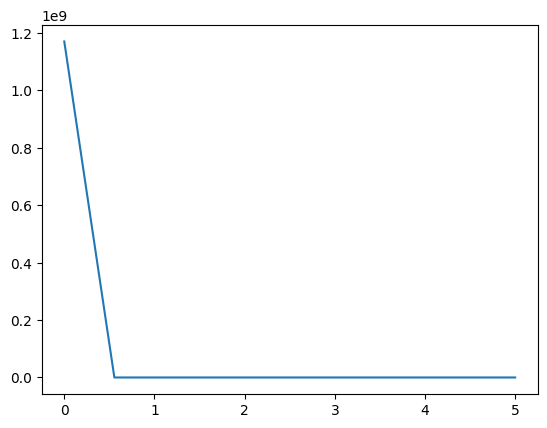

In [20]:
# Solve with Lasso
X = np.array(library_values).T[6:]
y = np.array(derivatives_values[0]).reshape(-1,1)[6:]


feature_names = library_names
alphas =  np.linspace(0,5,10)
best = float('inf')
pdes = []
rmses = []

for idx, alpha in enumerate(alphas):
    w,best_rmse = lasso_regression(X, y,alpha = alpha)
    pdes.append(print_pde(w,feature_names ,'d(V)'))
    rmses.append(best_rmse)
    if best_rmse < best:
        best_coef = w
        best = best_rmse
        best_idx = idx

print("PDE derived using STRidge")
plt.plot(alphas,rmses)
print(rmses[best_idx])
print(pdes[best_idx])

In [21]:
for p in pdes:
    if p is not None:
        print(p)

d(V) = (18.140983)(S) * (V)
 + (-82.744597)(S) * (V_S)
 + (213.753556)(S) * (V_SS)
 + (-1134.114766)(S) * (V_SSS)
 + (68.368598)(V) * (V_S)
 + (-749.442947)(V) * (V_SS)
 + (-56.231997)(V) * (V_SSS)
 + (144.580210)(V_S) * (V_SS)
 + (577.117559)(V_S) * (V_SSS)
 + (16258.927313)(V_SS) * (V_SSS)

d(V) = (17.109110)(S) * (V)
 + (-63.047023)(S) * (V_S)
 + (53.410624)(V) * (V_S)
 + (19.365376)(V_S) * (V_SS)

d(V) = (23.427635)(S) * (V)
 + (-50.569638)(S) * (V_S)
 + (33.593378)(V) * (V_S)
 + (9.633679)(V_S) * (V_SS)

d(V) = (29.668558)(S) * (V)
 + (-38.180377)(S) * (V_S)
 + (13.949489)(V) * (V_S)

d(V) = (32.243843)(S) * (V)
 + (-29.906390)(S) * (V_S)
 + (3.302776)(V) * (V_S)

d(V) = (30.757938)(S) * (V)
 + (-24.892288)(S) * (V_S)

d(V) = (27.441208)(S) * (V)
 + (-21.344818)(S) * (V_S)

d(V) = (24.116703)(S) * (V)
 + (-17.790516)(S) * (V_S)

d(V) = (20.800960)(S) * (V)
 + (-14.243912)(S) * (V_S)

d(V) = (17.485847)(S) * (V)
 + (-10.697862)(S) * (V_S)



PDE derived using STRidge
d(V) = (25.239561)(S) * (V)
 + (-46.405163)(S) * (V_S)
 + (1.209192)(S) * (V_SS)
 + (28.494325)(V) * (V_S)
 + (2.105827)(V) * (V_SS)
 + (11.295306)(V_S) * (V_SS)

408.1265369146366


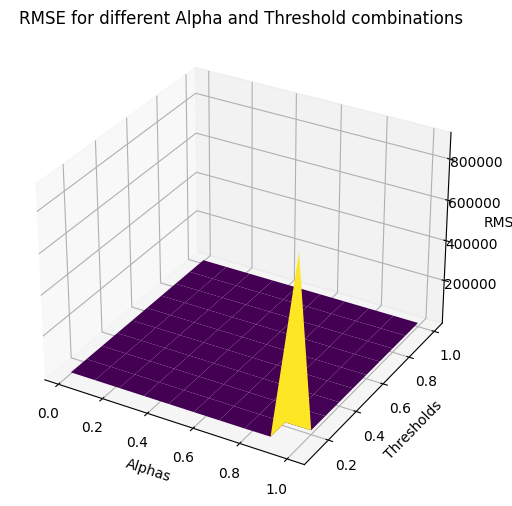

In [22]:
# Solve with Elastic-Net
X = np.array(library_values).T[6:]
y = np.array(derivatives_values[0]).reshape(-1,1)[6:]


feature_names = library_names
alphas = np.linspace(0.01,1.,10)
l1s = np.linspace(0.1,1.,10)

grid = np.array(np.meshgrid(alphas, l1s)).T.reshape(-1, 2)
best = float('inf')
pdes = []
rmses = []

for idx, obj in enumerate(grid):
    alpha, l1 = obj
    w,best_rmse = elastic_net_regression(X, y,alpha = alpha,l1_ratio = l1)
    pdes.append(print_pde(w,feature_names ,'d(V)'))
    rmses.append(best_rmse)
    if best_rmse < best:
        best_coef = w
        best = best_rmse
        best_idx = idx

print("PDE derived using STRidge")
print(pdes[best_idx])
print(rmses[best_idx])

# Create meshgrid for 3D plot
alpha_mesh, l1_mesh = np.meshgrid(alphas, l1s)

# Convert rmses to a 2D array for the mesh
rmses_mesh = np.array(rmses).reshape(len(alphas), len(l1s))

# Create the 3D plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(alpha_mesh, l1_mesh, rmses_mesh, cmap='viridis')

ax.set_xlabel('Alphas')
ax.set_ylabel('Thresholds')
ax.set_zlabel('RMSE')
plt.title("RMSE for different Alpha and Threshold combinations")

plt.show()


In [23]:
for p in pdes:
    if p is not None:
        print(p)

d(V) = (19.376157)(S) * (V)
 + (-63.909826)(S) * (V_S)
 + (4.646198)(S) * (V_SS)
 + (-2.661969)(S) * (V_SSS)
 + (52.558625)(V) * (V_S)
 + (5.027138)(V) * (V_SS)
 + (-3.367069)(V) * (V_SSS)
 + (18.953328)(V_S) * (V_SS)
 + (0.927591)(V_S) * (V_SSS)
 + (0.498987)(V_SS) * (V_SSS)

d(V) = (18.791271)(S) * (V)
 + (-64.900486)(S) * (V_S)
 + (4.630959)(S) * (V_SS)
 + (-2.827529)(S) * (V_SSS)
 + (54.174145)(V) * (V_S)
 + (4.851179)(V) * (V_SS)
 + (-3.631720)(V) * (V_SSS)
 + (19.568443)(V_S) * (V_SS)
 + (1.032345)(V_S) * (V_SSS)
 + (0.424074)(V_SS) * (V_SSS)

d(V) = (18.149592)(S) * (V)
 + (-65.945254)(S) * (V_S)
 + (4.579320)(S) * (V_SS)
 + (-3.032677)(S) * (V_SSS)
 + (55.903226)(V) * (V_S)
 + (4.581694)(V) * (V_SS)
 + (-3.963965)(V) * (V_SSS)
 + (20.257943)(V_S) * (V_SS)
 + (1.175816)(V_S) * (V_SSS)
 + (0.327016)(V_SS) * (V_SSS)

d(V) = (17.443868)(S) * (V)
 + (-67.050339)(S) * (V_S)
 + (4.472311)(S) * (V_SS)
 + (-3.298123)(S) * (V_SSS)
 + (57.759650)(V) * (V_S)
 + (4.168986)(V) * (V_SS)
 + (-

PDE derived using STRidge
V_t = (-36.931033)(S) * (V_S)
 + (30.649846)(V) * (V_S)

1409.984815709878


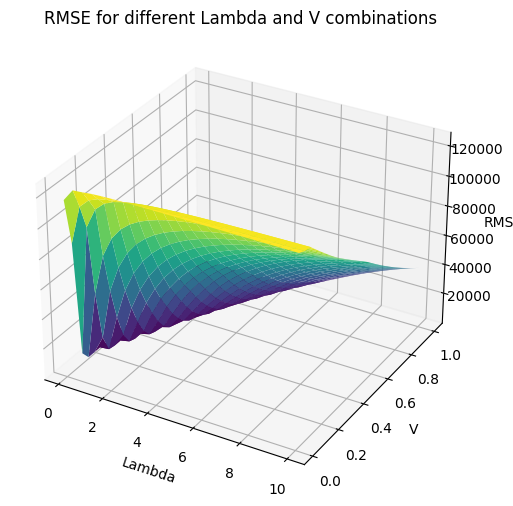

In [24]:
# Solve with SR3
X = np.array(library_values).T[6:]
y = np.array(derivatives_values[0]).reshape(-1,1)[6:]


feature_names = library_names
lambdas = np.linspace(0.1,10,num=25)
els = np.linspace(0.01,1.,25)

grid = np.array(np.meshgrid(lambdas, els)).T.reshape(-1, 2)
best = float('inf')
pdes = []
rmses = []

for idx, obj in enumerate(grid):
    lam, l1 = obj
    w,best_rmse = SR3_regression(X, y,lam = lam,el = l1)
    pdes.append(print_pde(w['x'],feature_names ,'V_t'))
    rmses.append(best_rmse)
    if best_rmse < best:
        best_coef = w
        best = best_rmse
        best_idx = idx

print("PDE derived using STRidge")
print(pdes[best_idx])
print(rmses[best_idx])

# Create meshgrid for 3D plot
lam_mesh, el_mesh = np.meshgrid(lambdas, els)

# Convert rmses to a 2D array for the mesh
rmses_mesh = np.array(rmses).reshape(len(lambdas), len(els))

# Create the 3D plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(lam_mesh, el_mesh, rmses_mesh, cmap='viridis')

ax.set_xlabel('Lambda')
ax.set_ylabel('V')
ax.set_zlabel('RMSE')
plt.title("RMSE for different Lambda and V combinations")

plt.show()


In [25]:
for p in pdes:
    if p is not None:
        print(p)

V_t = (10.579138)(S) * (V)
 + (-77.299053)(S) * (V_S)
 + (234.261921)(S) * (V_SS)
 + (-1238.421592)(S) * (V_SSS)
 + (64.148032)(V) * (V_S)
 + (-541.517288)(V) * (V_SS)
 + (100.142857)(V_S) * (V_SS)
 + (440.707997)(V_S) * (V_SSS)
 + (1131.895461)(V_SS) * (V_SSS)

V_t = (18.398753)(S) * (V)
 + (-85.179777)(S) * (V_S)
 + (238.553582)(S) * (V_SS)
 + (-1226.247862)(S) * (V_SSS)
 + (72.290545)(V) * (V_S)
 + (-542.208515)(V) * (V_SS)
 + (107.215277)(V_S) * (V_SS)
 + (440.070605)(V_S) * (V_SSS)
 + (1112.626461)(V_SS) * (V_SSS)

V_t = (18.668100)(S) * (V)
 + (-85.989499)(S) * (V_S)
 + (231.537150)(S) * (V_SS)
 + (-936.713197)(S) * (V_SSS)
 + (73.682926)(V) * (V_S)
 + (-528.167974)(V) * (V_SS)
 + (-196.495698)(V) * (V_SSS)
 + (105.681848)(V_S) * (V_SS)
 + (399.127694)(V_S) * (V_SSS)
 + (987.101171)(V_SS) * (V_SSS)

V_t = (18.676895)(S) * (V)
 + (-86.323706)(S) * (V_S)
 + (227.482809)(S) * (V_SS)
 + (-761.887821)(S) * (V_SSS)
 + (74.325512)(V) * (V_S)
 + (-521.009905)(V) * (V_SS)
 + (-319.277355)